In [5]:
######### MODULES ##########
import sys, os, re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate as spinter, optimize as spopt
from delta_method import delta_method, parametric_bootstrap
plt.rcParams.update({'font.size':14, "xtick.direction":"in", "ytick.direction":"in"})
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', 500)

In [6]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

In [7]:
###########SHINY NEW FUNCTIONS###############

def polynomial(x, *coeffs):
    x = np.array(x)
    y = np.sum([coeff*x**n for n, coeff in enumerate(coeffs)], axis= 0)
    return y

def reciplical_polynomial(x, *coeffs):
    x = np.array(x)
    y = np.sum([coeff*(x+coeffs[0])**-n if n != 0 else np.zeros_like(x) for n, coeff in enumerate(coeffs)], axis= 0)
    return y

def flatten_2d_list(bookshelf):
    return [page for book in bookshelf for page in book]

def flatten_3d_list(library): #Would be nice to know the number of dimentions of a list. This is not easy. :( I can only use np.arrays if the list is 'rectangular'.
    return [page for bookshelf in library for book in bookshelf for page in book]

def roll_average(xs, ys, number_of_points= 100, window_width=1):
    xs = flatten_3d_list(xs)
    ys = flatten_3d_list(ys)

    points = np.linspace(np.nanmin(xs), np.nanmax(xs), number_of_points)
    average = []
    uncertainty = []
    
    for point in points:
        points_in_window = [ys[n] for n, x in enumerate(xs) if x-window_width < point and point < x+window_width] #create a list of points inside the window
        average = average + [np.nanmean(points_in_window)]
        uncertainty = uncertainty + [np.nanstd(points_in_window)]

    return points, average, uncertainty

def polynomial_fit(xs, ys, number_of_points= 100, x0= [1, -0.13, 0.2, -0.09, 0], confidence= 0.1, reciplical= False, silent= False):
    xs, ys = flatten_3d_list(xs), flatten_3d_list(ys)
    is_valid = np.logical_and(~np.isnan(xs), ~np.isnan(ys))
    xs, ys = np.array(xs)[is_valid], np.array(ys)[is_valid] #remove nans

    model_function = reciplical_polynomial if reciplical else polynomial


    points = np.linspace(np.nanmin(xs), np.nanmax(xs), number_of_points)

    popt, pcov = spopt.curve_fit(model_function, xs, ys, p0= x0, nan_policy= "omit", method= "trf", loss= "cauchy") # loss = "linear" for least squares. "huber" "soft_l1" "cauchy" "arctan"
    delta = delta_method(pcov, popt, points, model_function, xs, ys, confidence)

    poly_fit = model_function(points, *popt)

    if not silent:
        print("Optimal coeffients:")
        print(*popt)

    return points, poly_fit, delta


def read_metadata(requested_data): #DO NOT OPEN MULTIPLE SHEETS AT ONCE. OPEN THE SHOT SHEET AND TARGET SHEET SEPERATELY!
    shot_list = ["SHOT #","Date","Time","Purpose","Target X","Target Y","Target Z","Wheel XPS","position on wheel","TARGET NUMBER","Laser Energy (before comp) [J]","Laser duration [fs]","Horiz ns/div","Trigger val [mV]","C1 [V/div]","C2 [V/div]","C3 [V/div]","C4 [V/div]","C1 att [dB]","C2 att [dB]","C3 att [dB]","C1 diag","C2 diag","C3 diag","C4 diag","Comments JLD scope","THz comments","Column2","X-ray comments","Column3","Column4","Column5"]
    target_list = ["Date","Number","Position in the box","Wheel","Position on the wheel","Rotation angle(TARGET)","XYZ (TARGET)","Thickness (um)","Length(mm)","Material","Type","Comments"]

    if requested_data[0] in shot_list : sheet, header_row = "Shot-list", 1 # weird python syntax
    if requested_data[0] in target_list : sheet, header_row = "Target list", 0

    dataframe = pd.read_excel(io= "organised_data\\Shots_Targets_Diagnostics.xlsx", # numpy is bad at reading excel files.
                              sheet_name= sheet,
                              header= header_row,
                              usecols= requested_data)
    
    dictionary = dataframe.to_dict(orient= "list")
    return dictionary

def open_pyro_oscilloscope(requested_data, shots, file_directories, file_names, silent= False):
    channel = "Ch1" if requested_data == "pyro_time" else requested_data
    regex_code = ".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*"+channel+".csv"
    match = [bool(re.findall(regex_code, file_name)) for file_name in file_names]
    filtered_file_directories = file_directories[match]
    filtered_file_names = file_names[match]
    number_of_files = len(filtered_file_names)
    filtered_file_paths = [os.path.join(filtered_file_directories[n],filtered_file_names[n]) for n in range(number_of_files)]
                            
    shot_no = [int(re.search(regex_code, filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
    pyro_data = [np.genfromtxt(filtered_file_path, delimiter=',', skip_header =0, usecols= 3 if requested_data == "pyro_time" else 4) for filtered_file_path in filtered_file_paths]

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return shot_no, pyro_data

def open_emp_oscilloscope(requested_data, shots, file_directories, file_names, silent= False):
    emp_oscilloscope_data = ["time","bdot","tof","diode"]
    column = emp_oscilloscope_data.index(requested_data)
    regex_code = "(?i)s0*("+'|'.join(shots)+")[^0-9]*\.csv"
    match = [bool(re.findall(regex_code, file_name)) for file_name in file_names]
    filtered_file_directories = file_directories[match]
    filtered_file_names = file_names[match]
    number_of_files = len(filtered_file_names)
    filtered_file_paths = [os.path.join(filtered_file_directories[n],filtered_file_names[n]) for n in range(number_of_files)]

    shot_no = [int(re.search(regex_code, filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
    emp_data = [np.genfromtxt(filtered_file_path, delimiter=',', skip_header =18, usecols= column) for filtered_file_path in filtered_file_paths]

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return shot_no, emp_data

def read_diagnostic_data(requested_data, silent= False): #Currently supports the pyro oscilloscope and the emp oscilloscope. Doesn't support target photos, espec, xray cam, focal spot cam and pyrocams. 
    data_path = "organised_data\\"
    dictionary = {"shot":[]}
    emp_oscilloscope_data = ["time","bdot","tof","diode"]
    pyro_oscilloscope_data = ["Ch1","Ch2","Ch3","Ch4","pyro_time"]

    all_file_directories = [root for root, dirs, files in os.walk(data_path) for file in files]
    all_file_directories = np.array(all_file_directories)
    all_file_names = [file for root, dirs, files in os.walk(data_path) for file in files]
    all_file_names = np.array(all_file_names)
    requested_data = {ch: [str(int(shot)) for shot in shots] for ch, shots in requested_data.items()} # ensure that all shot numbers are strings of ints. floats will screw up regex.

    for request, shots in requested_data.items():
        if request in pyro_oscilloscope_data:
            new_shots, new_data = open_pyro_oscilloscope(request, shots, all_file_directories, all_file_names, silent= silent)
        elif request in emp_oscilloscope_data:
            new_shots, new_data = open_emp_oscilloscope(request, shots, all_file_directories, all_file_names, silent= silent)
        else:
            new_shots, new_data = [], []
            print("WARNING!! {0} is not a recognised data type.".format(request))

        old_shots = dictionary["shot"]
        union_shots = np.unique(old_shots + new_shots).tolist()

        dictionary = {diagnostic: [readings[old_shots.index(shot)] if shot in old_shots else np.nan for shot in union_shots] for diagnostic, readings in dictionary.items()} #rearrange the existing data to corrispond with its respective shot
        dictionary[request] = [new_data[new_shots.index(shot)] if shot in new_shots else np.nan for shot in union_shots] # Add the new data to it's respective shot.
        dictionary["shot"] = union_shots #add the new shots

    return dictionary

In [8]:
shotsheet = read_metadata(["SHOT #","Target X","Target Z","TARGET NUMBER","Laser Energy (before comp) [J]"])
targetsheet = read_metadata(["Number","Wheel"])

total_number_of_shots = len(shotsheet["SHOT #"])

for key in shotsheet.keys():
    shotsheet[key] = [np.nan if re.search('[^\d.]', str(value)) else float(value) for value in shotsheet[key]] # Filter out all numberic characters. Numeric characters being: `0123456789.`

shotsheet["Wheel"] = [targetsheet["Wheel"][targetsheet["Number"].index(target_number)] if target_number in targetsheet["Number"] else np.nan for target_number in shotsheet["TARGET NUMBER"]] # give each target it's respective wheel. 

In [9]:
 ###Initialisation
target = 0
shotsheet["relative X"] = np.full(len(shotsheet["SHOT #"]), fill_value= np.nan)
shotsheet["relative Z"] = np.full(len(shotsheet["SHOT #"]), fill_value= np.nan)
###Loop over all shots
for n in range(total_number_of_shots):
    if shotsheet["TARGET NUMBER"][n] != target:
        delta_x = shotsheet["Target X"][n]
        delta_z = shotsheet["Target Z"][n]
        target = shotsheet["TARGET NUMBER"][n] # ASSUMES THAT WE DON'T RETURN BACK TO THE SAME TARGET.

    shotsheet["relative X"][n] = shotsheet["Target X"][n] -delta_x #make the target movement in x relitive to the first shot
    shotsheet["relative Z"][n] = shotsheet["Target Z"][n] -delta_z #make the target movement in z relitive to the first shot

shotsheet["d"] = np.linalg.norm([shotsheet["relative X"], shotsheet["relative Z"]], axis= 0) # pythagorus to find d. This might be a little simplistic since we know the angle should be 25°

### Choose which targets and channels to use here!

`targets` is a dictionary with the pyroelectric channels and corrisponding target numbers. These targets will be analysised and plotted (if the relevant .csv data file exists). For example,
```
targets = {"Ch2": [105,106],
           "Ch3": [66,67,69,90,105,106],
           "Ch4": [66,67,69,86]}
```

`emp` is a dictionary with the pyroelectric emp channels and corrisponding target numbers. This will be used for background subtraction. Every target in `targets` must also appear here. For example,
```
emp = {"Ch1": [90,105,106],
       "Ch2": [66,67,69,81,86]}
```

`oscilloscope` is very simular to `targets` except it will not be background subtracted. It will be plotted as the bdot data. Every target in `targets` should also appear here. For example,
```
oscilloscope = {"bdot": [66,67,69,86,90,105,106]}
```

In [10]:
targets = {"Ch2": [105,106],
           "Ch3": [66,67,69,90,105,106],
           "Ch4": [66,67,69,86]}
emp = {"Ch1": [90,105,106,108],
       "Ch2": [66,67,69,81,86]}
oscilloscope = {"bdot": [66,67,69,86,90,105,106]}

emp_lookup = {t: ch for ch, target in emp.items() for t in target} #Create a target -> channel lookup table.
emp_lookup = {shotsheet["SHOT #"][n]: ch for n in range(total_number_of_shots) for t, ch in emp_lookup.items() if shotsheet["TARGET NUMBER"][n] == t} #Convert to a shot -> channel lookup table.
emp = {ch: [shotsheet["SHOT #"][n] for t in target for n in range(total_number_of_shots) if shotsheet["TARGET NUMBER"][n] == t] for ch, target in {**emp, **oscilloscope}.items()} #find the respective shots for these targets. Include both pyro emp and osc emp data mearly to ensure that has the same indexes as the next dictionary
shots = {ch: [shotsheet["SHOT #"][n] for t in target for n in range(total_number_of_shots) if shotsheet["TARGET NUMBER"][n] == t] for ch, target in {**targets, **oscilloscope}.items()} #find the respective shots for these targets. Include both the target and emp data
pyro_shots = {ch: [shotsheet["SHOT #"][n] for t in target for n in range(total_number_of_shots) if shotsheet["TARGET NUMBER"][n] == t] for ch, target in {**targets}.items()} #Lazy solution

pyro_emp = read_diagnostic_data(emp, silent= True)
pyro = read_diagnostic_data(shots, silent= True)

In [11]:
pyro_shots = flatten_2d_list(pyro_shots.values())

### Background subtraction
Comment this out to remove background subtraction. The bdot is exempt from background subtraction because it is not in `targets`. 

In [12]:
pyro = {key: [
             np.subtract( # Background subtract
                pyro[key][pyro["shot"].index(shot)], # signal on channel `key`
                pyro_emp[emp_lookup[shot]][pyro_emp["shot"].index(shot)]) # EMP background on channel `emp_lookup[shot]`
             if shot in pyro_shots else pyro[key][pyro["shot"].index(shot)]
             for shot in pyro["shot"] # for every shot
             ]
             if key in targets.keys() else pyro[key] # only pyroelectric channels should be subject to background subtraction
             for key in pyro.keys()} # for every channel

### Calculate minima of every channel
The diagnostic data within `pyro` also gets merged with the metadata within `shotsheet`.

In [13]:
pyro = {key: [np.abs(np.nanmin(shot)) for shot in pyro[key]] if key in targets.keys() else pyro[key] for key in pyro.keys()} #find the minima of every shot
pyro = {key: [np.ptp(shot) for shot in pyro[key]] if key == "bdot" else pyro[key] for key in pyro.keys()} #find the range of every shot

for key in pyro.keys():
    if key != "shot":
        shotsheet[key] = [pyro[key][pyro["shot"].index(shot)] if shot in pyro["shot"] else np.nan for shot in shotsheet["SHOT #"]] #add channel minima to the shotsheet on respective shot numbers

C:\Users\syf83691\AppData\Local\Temp\ipykernel_26724\1254914013.py:1: RuntimeWarning: All-NaN slice encountered
  pyro = {key: [np.abs(np.nanmin(shot)) for shot in pyro[key]] if key in targets.keys() else pyro[key] for key in pyro.keys()} #find the minima of every shot
C:\Users\syf83691\AppData\Local\Temp\ipykernel_26724\1254914013.py:1: RuntimeWarning: All-NaN axis encountered
  pyro = {key: [np.abs(np.nanmin(shot)) for shot in pyro[key]] if key in targets.keys() else pyro[key] for key in pyro.keys()} #find the minima of every shot


### Reorganise data by target
The reorganised data is saved in a new dictionary called `dataset`.

In [14]:
flat_targets = np.unique(flatten_2d_list(oscilloscope.values())) #create a list of targets without channel infomation

### initialise
dataset = {}
dataset["d"] = [[shotsheet["d"][n] for n in range(total_number_of_shots) if shotsheet["TARGET NUMBER"][n] == target] for target in flat_targets] # displacement must also be initialised because it determines which data sets are valid

### loop over all other data sets
for key in shotsheet.keys():
    if key != "d":
        dataset[key] = [[shotsheet[key][n] for n in range(total_number_of_shots) if shotsheet["TARGET NUMBER"][n] == target] for target in flat_targets] #change shape so that shots on the same target are grouped together
        dataset[key] = [target for m, target in enumerate(dataset[key]) if len(dataset["d"][m]) > 0] #filter out targets with no displacement data. (targets that were never shot)
    if key in ["TARGET NUMBER","Wheel"]:
        dataset[key] = [target[0] for target in dataset[key]] #these do not change when the target number is constant. Remove list.

### finalise
dataset["d"] = [target for target in dataset["d"] if len(target) > 0]

### Normalisation
Comment out line 3 to stop energy normalisation. Comment out line 4 to stop normalisation to the first shot on the target.

In [15]:
### loop over all channels
for ch in {**targets, **oscilloscope}.keys(): #loop over all diagnostic data
    dataset[ch] = [np.array(target)/np.array(dataset["Laser Energy (before comp) [J]"][n]) for n, target in enumerate(dataset[ch])] #normalise all channels for laser energy
    dataset[ch] = [np.array(target)/target[0] if ~np.isnan(target[0]) else np.array(target) for target in dataset[ch]] #normalise all channels such that they start on 1 (or np.nan).

### Setup parameters for graph

In [16]:
plot = list(targets.keys()) #list of channels to plot. Use `list(targets.keys())` for all channels. MUST be a list even if there is only one channel. eg. ["Ch3"]

### best fit parameters
number_of_points = 100 #number of points for the best fit line.
#rolling_width = 0.35 #half width. only used by roll_average
confidence= 0.05 #only used by polynomial_fit

### Calculate best fit
Use `polynomial_fit` or `roll_average`.


`polynomial_fit(xs, ys, number_of_points, x0, confidence, reciplical)` where `xs` is a list of x (displacement) values to be fitted. `ys` is a list of y (voltage) values to be fitted. The `number_of_points` is the number of points of the best fit model to return. Higher values increase the resolution of the best fit line. `x0` is the 'inital guess' of the best fitting algorithm. It also detemines the order of the polynomial. eg. `x0 = [2, 0, -1]` will use y= -x<sup>2</sup> +2 as the initial guess and then fit the datapoints to a quadratic, `x0= [1, -1, 0.5, 0]` will start with y= 0.5x<sup>2</sup> -x +1 as the initial guess and then fit the datapoints to a cubic. `confidence` is the level of confidence of the delta function. `reciplical` changes all terms in the polynomial to its reciplical. eg. `x0 = [2, 0, -1], reciplical= True` will use y= -(x+2)<sup>-2</sup> as its initial guess and then fit to y = a(x+c)<sup>-2</sup> + b(x+c)<sup>-1</sup>


`roll_average(xs, ys, number_of_points, window_width)` where `xs` is a list of x (displacement) values. `ys` is a list of y (voltage) values. The `number_of_points` is the number of points of the best fit model to return. Higher values increase the resolution of the best fit line. The `window_width` is the half-width of the rolling average window. Increase this to make the the model smoother. 

In [17]:
### best fit
pyro_fit_x, pyro_fit_y, pyro_fit_delta = polynomial_fit([dataset["d"] for ch in plot],
                                                        [dataset[ch] for ch in plot],
                                                        number_of_points= number_of_points,
                                                        x0= [1, -1],
                                                        confidence= confidence)

bdot_fit_x, bdot_fit_y, bdot_fit_delta = polynomial_fit([dataset["d"] for ch in plot],
                                                        # find the corrisponding bdot data unless the pyro data is missing.
                                                        [[dataset["bdot"][target] if ~np.all(np.isnan(dataset[ch][target])) else np.full_like(dataset["bdot"][target], np.nan) for target in range(len(dataset["TARGET NUMBER"]))] for ch in plot],
                                                        number_of_points= number_of_points,
                                                        x0= [1, 0],
                                                        confidence= confidence)

Optimal coeffients:
0.9575608795122313 -0.16287954280906097
Optimal coeffients:
1.032104154945051 -0.07183615818441706


### Graph itslef

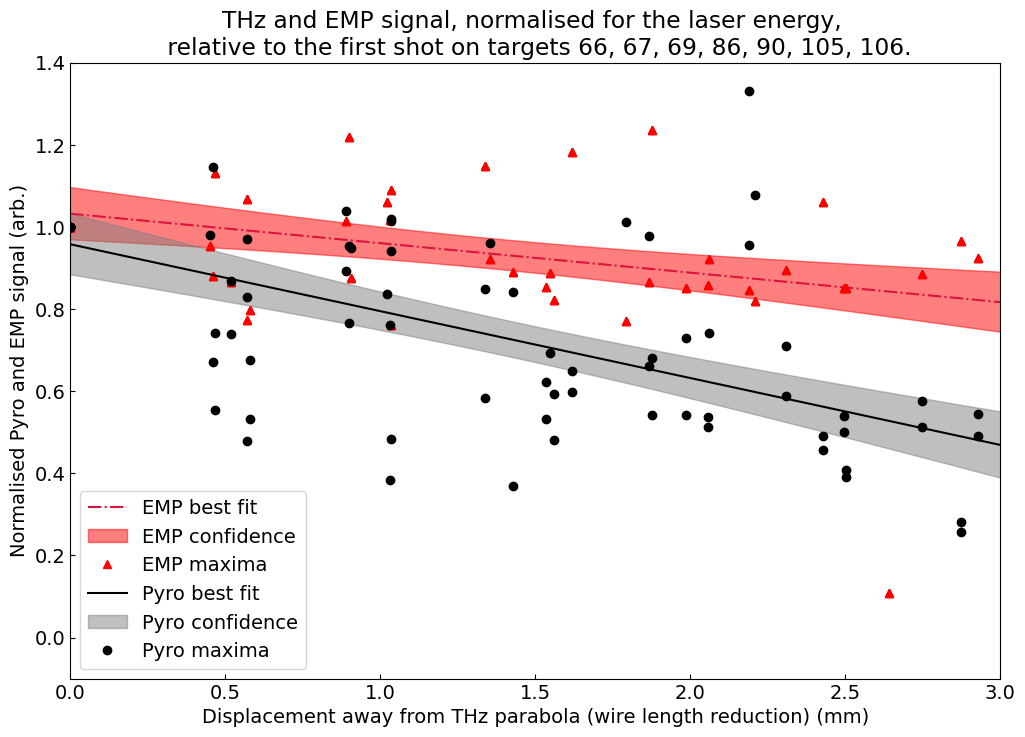

In [19]:
fig, axs = plt.subplots(1, 1, figsize= (12,8))

### PLOT BDOT
# bdot best fit
axs.plot(bdot_fit_x,
        bdot_fit_y,
        color= "crimson",
        linestyle= "-.",
        label= "EMP best fit")
# bdot best fit uncertainty
axs.fill_between(bdot_fit_x,
                    bdot_fit_delta['lwr_conf'],
                    bdot_fit_delta['upr_conf'],
                    color= "red",
                    alpha= 0.5,
                    label= "EMP confidence")
# bdot datapoints
axs.plot(flatten_3d_list([dataset["d"] for ch in plot]),
         # find the corrisponding bdot data unless the pyro data is missing.
        flatten_3d_list([[dataset["bdot"][target] for target in range(len(dataset["TARGET NUMBER"]))] for ch in plot]),
        color= "red",
        linestyle= "None",
        marker= "^",
        label= "EMP maxima")
### PLOT PYRO
# pyro best fit
axs.plot(pyro_fit_x,
        pyro_fit_y,
        color= "k",
        label= "Pyro best fit")
# pyro best fit uncertainty
axs.fill_between(pyro_fit_x,
                pyro_fit_delta['lwr_conf'],
                pyro_fit_delta['upr_conf'],
                color= "gray",
                alpha= 0.5,
                label= "Pyro confidence")
# pyro datapoints
axs.plot(flatten_2d_list([dataset["d"][dataset["TARGET NUMBER"].index(target)] for ch in plot for target in targets[ch]]),
        flatten_2d_list([dataset[ch][dataset["TARGET NUMBER"].index(target)] for ch in plot for target in targets[ch]]),
        color= "k",
        marker = "o",
        linestyle= "None",
        label= "Pyro maxima")

axs.set(xlabel= "Displacement away from THz parabola (wire length reduction) (mm)", # x axis label
        ylabel= "Normalised Pyro and EMP signal (arb.)", # y axis label
        xlim= (0, 3), # x limits
        ylim= (-0.1, 1.4), #y limits
        title= "THz and EMP signal, normalised for the laser energy, \n relative to the first shot on targets " + ", ".join(flat_targets.astype(str)) + ".") #title

axs.legend(loc= "lower left") # loc fixes the location of the legend. 

plt.show()